TokaMaker Example: LDX-like dipole equilibrium and stability {#doc_tMaker_dipole_ex2}
==========
In this example we demonstrate:

 1. How to create a simple LDX-like dipole equilibrium
 2. How to compute linear growth rates for the floating magnet

This example utilizes the mesh built in \ref doc_tMaker_dipole_ex1.

**Warning:** Dipole equilibrium support is still in development. Please be careful when using this feature and report any issues.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, create_spline_flux_fun

## Setup calculation

### Initialize TokaMaker object
We now create a \ref OpenFUSIONToolkit.OFT_env "OFT_env" instance for execution using two threads and a \ref OpenFUSIONToolkit.TokaMaker.TokaMaker "TokaMaker" instance to use for equilibrium calculations. Note at present only a single `TokaMaker` instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
myenv = OFT_env(nthreads=1)
mygs = TokaMaker(myenv)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          05a5f68
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    1
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_75114/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated in \ref doc_tMaker_dipole_ex1 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh". Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions()", passing the conductor and coil dictionaries for the mesh, to define the different region types. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4).

**Note:** We also need to set `settings.dipole_mode=True` to set dipole specific options for TokaMaker.

In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('dipole_mesh.h5')
mygs.settings.dipole_mode=True
mygs.settings.maxits=80
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2)


**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  1.411E+01
    # of points  =    8546
    # of edges   =   25457
    # of cells   =   16912
    # of boundary points =     178
    # of boundary edges  =     178
    # of boundary cells  =     178
  Resolution statistics:
    hmin =  1.253E-02
    hrms =  4.646E-02
    hmax =  1.801E-01
  Surface grounded at vertex     181


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    3.4919999999999999E-003


## Compute force on dipole from levitation/shaping coil
As the name suggests, a levitated dipole is supported by the magnetic interaction of the floating coil (dipole) and an external levitation coil, which is located above the dipole in most machines due to stability considerations. Therefore the current in each coils needs to be consistent with the required force to support the dipole.

### Compute levitation coil vacuum field
To compute this force, we first compute the vacuum field associated with the levitation coil for unit current (1 Amp).

   1  1.8648E-04


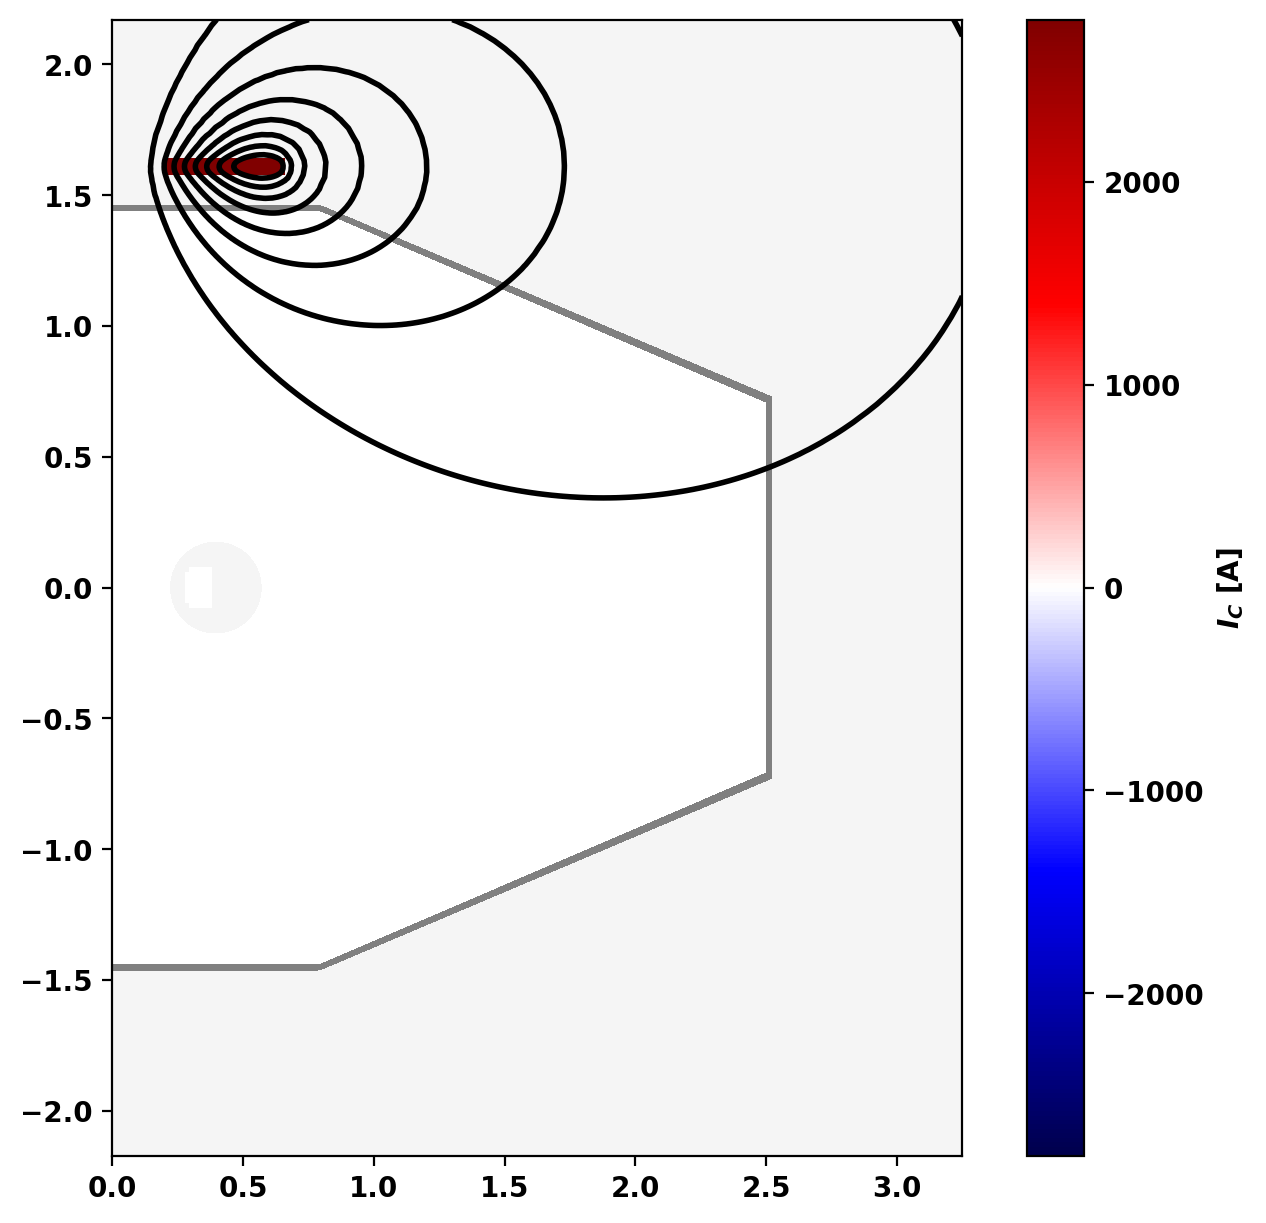

In [5]:
# Compute vacuum field with unit current in Lcoil
coil_currents = {'FCOIL': 0.0, 'LCOIL': 1.0}
mygs.set_coil_currents(coil_currents)
psi_lev = mygs.vac_solve()

# Plot field
fig, ax = plt.subplots(1,1,sharey=True,figsize=(8,6),constrained_layout=True)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,limiter_color=None)
mygs.plot_psi(fig,ax,psi=psi_lev,normalized=False,plasma_nlevels=10,plasma_color='k',vacuum_levels=None,xpoint_color=None,opoint_color=None)

### Compute B-field and forces
Now we compute the magnetic field from the levitation coil within the dipole using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_field_eval "get_field_eval()" and then integrate to compute the force using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.area_integral "area_integral()". Note that the current density in "normal" coils in TokaMaker is uniform so the poloidal integrand is simply $- 2 \pi r \frac{N_{turns}}{A_C} B_r $, $N_{turns}$ and $A_C$ are the number of turns and area of the coil.

For this case our floating coil is composed of only a single contiguous region. However, we still use loops over sub-coils to demonstrate how to perform these calculations in a general way where more than one sub-coil may be used.

Force on Fcoil due to Lcoil coil [N/A^2]: 2.9065E-02


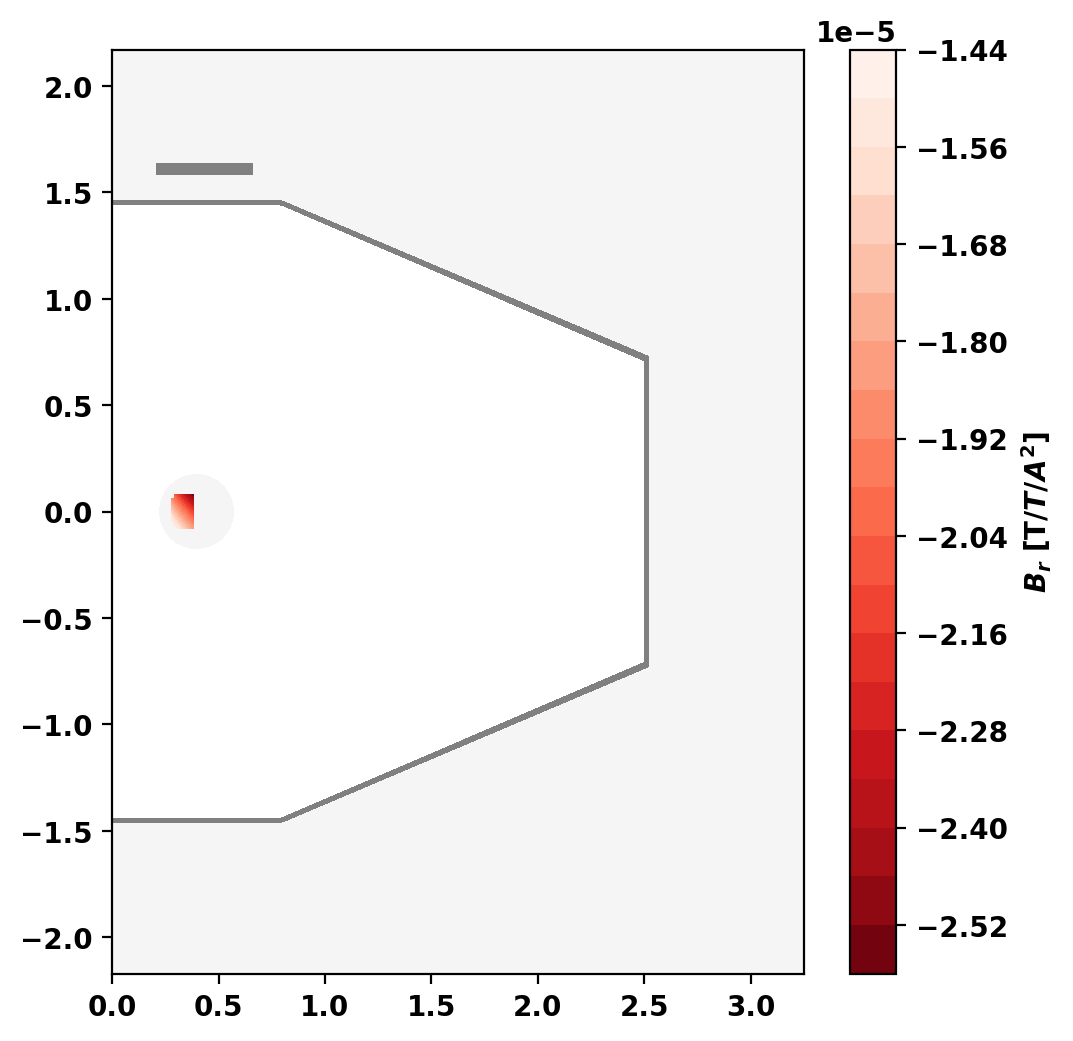

In [6]:
# Compute masks for vertices and cells that form part of the floating coil
pt_mask = np.zeros((mygs.r.shape[0],), dtype=np.int32)
cell_mask = np.zeros((mygs.lc.shape[0],), dtype=np.int32)
for sub_coil in mygs.coil_sets['FCOIL']['sub_coils']:
    pt_mask[mygs.lc[mygs.reg==sub_coil['reg_id'],:]] = 1
    cell_mask[mygs.reg==sub_coil['reg_id']] = 1
    
# Evaluate radial field within Fcoil
mygs.set_psi(psi_lev)
field_eval = mygs.get_field_eval('B')
Br_dipole = np.zeros((mygs.r.shape[0],))
for i in range(mygs.r.shape[0]):
    if pt_mask[i] == 0:
        continue
    Btmp = field_eval.eval(mygs.r[i,:2])
    Br_dipole[i] = Btmp[0]

# Plot radial field in Fcoil
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
clf = ax.tricontourf(mygs.r[:,0],mygs.r[:,1],mygs.lc[cell_mask==1,:],Br_dipole,levels=20,cmap='Reds_r')
fig.colorbar(clf,ax=ax,label=r'$B_r$ [T/$T/A^2$]')

# Compute total force on Fcoil per Amp in Lcoil and Fcoil
unit_coil_force = 0.0
for sub_coil in mygs.coil_sets['FCOIL']['sub_coils']:
    sub_coil['area'] = mygs.area_integral(np.ones_like(Br_dipole),reg_mask=sub_coil['reg_id'])
    unit_coil_force += -2.0*np.pi*mygs.area_integral(mygs.r[:,0]*Br_dipole,reg_mask=sub_coil['reg_id'])*sub_coil['nturns']/sub_coil['area']

# Print total force per Amp in Lcoil and Fcoil
print('Force on Fcoil due to Lcoil coil [N/A^2]: {0:.4E}'.format(unit_coil_force))

## Compute stability of dipole in vacuum field
As the coil is not rigidly supported it can also be susceptible to a vertical instability where the coil itself moves upward or downward. To compute the growth rate for this instability we need to look at the variation of the force under displacement of the Fcoil in z. This can be done using a similar process as the force, but replacing the magnetic field with its gradient $\frac{\partial B_r}{\partial z}$.

In this case the value should positive, which indicates an unstable system as expected.

**Note:** The reason this instability is OK is that avoiding it in general results in other more challenging instabilities arising.

dF/dz due to motion of Fcoil (positive is unstable) = 6.1903E-02


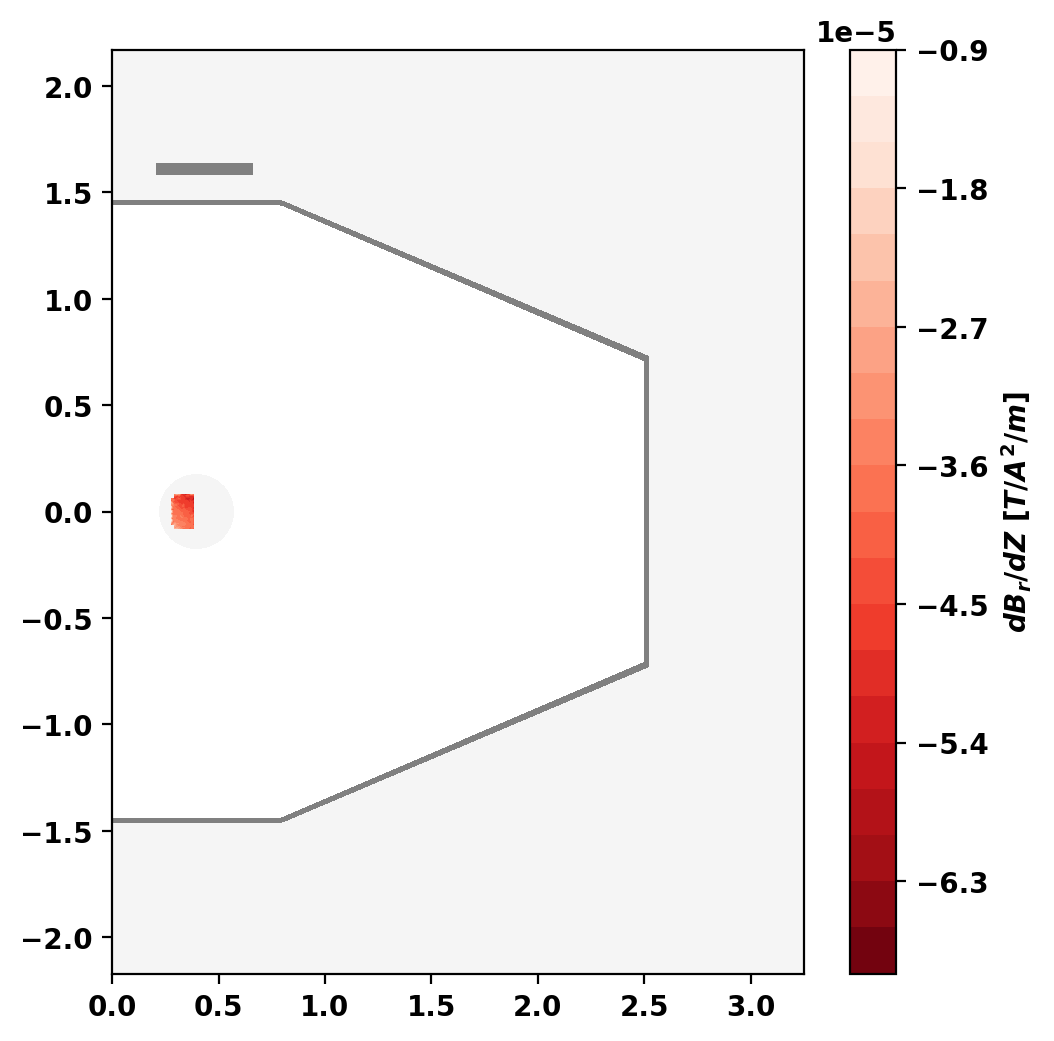

In [7]:
# Evaluate dBr/dz within Fcoil
field_eval = mygs.get_field_eval('dBr')
dBrdZ_dipole = np.zeros((mygs.r.shape[0],))
for i in range(mygs.r.shape[0]):
    if pt_mask[i] == 0:
        continue
    Btmp = field_eval.eval(mygs.r[i,:2])
    dBrdZ_dipole[i] = Btmp[1]

# Plot dBr/dz in Fcoil
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
clf = ax.tricontourf(mygs.r[:,0],mygs.r[:,1],mygs.lc[cell_mask==1,:],dBrdZ_dipole,levels=20,cmap='Reds_r')
fig.colorbar(clf,ax=ax,label=r'$dB_r/dZ$ [$T/A^2/m$]')

# Compute net vertical force gradient on Fcoil per Amp in Lcoil and Fcoil
unit_coil_force_dz = 0.0
for sub_coil in mygs.coil_sets['FCOIL']['sub_coils']:
    unit_coil_force_dz += -2.0*np.pi*mygs.area_integral(mygs.r[:,0]*dBrdZ_dipole,reg_mask=sub_coil['reg_id'])*sub_coil['nturns']/sub_coil['area']

# Print total vertical force gradient per Amp in Lcoil and Fcoil
print('dF/dz due to motion of Fcoil (positive is unstable) = {0:.4E}'.format(unit_coil_force_dz))

## Compute dipole equilibrium
After computing the required values for force balance we can now compute an equilibrium for our device. The first consideration is force balance on the coil, which is dependent on the current in both the Fcoil and the Lcoil. For this equilibrium we set the Fcoil (dipole) to it's maximum nominal current as used in LDX, which is 1.5 MA, and use the corresponding mass of the LDX levitated structure, which was 560 kg.

   1  5.7878E+01


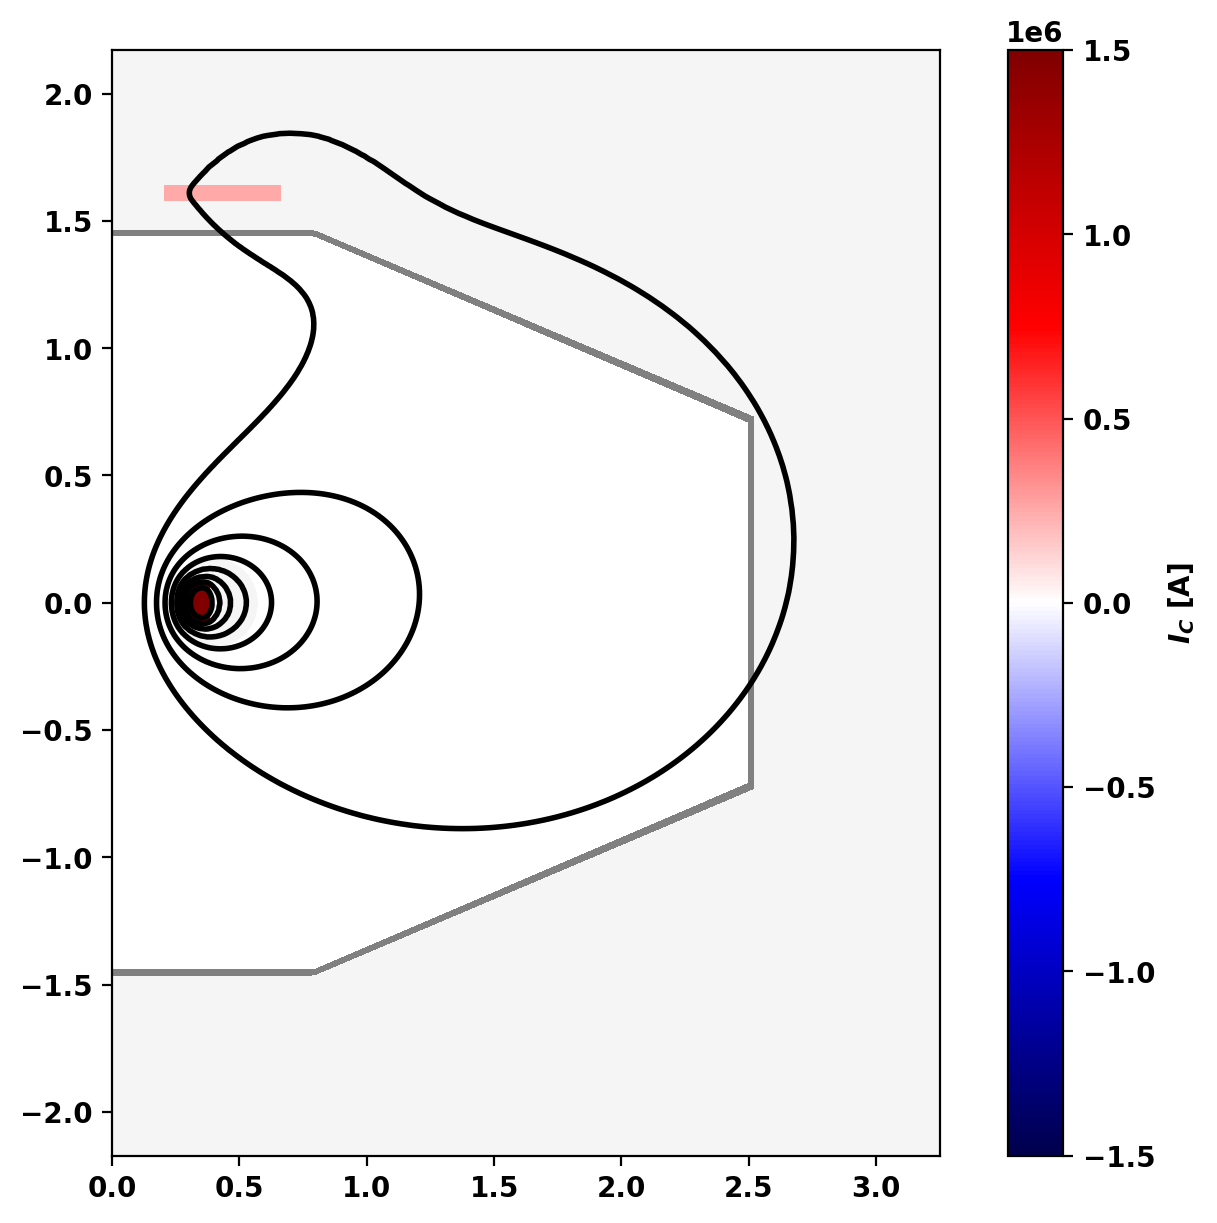

In [8]:
# Compute coil currents required for force balance
dipole_mass = 560.0 # Mass of LDX coil
coil_currents = {'FCOIL': 1.5E6/mygs.coil_sets["FCOIL"]['net_turns']}
coil_currents['LCOIL'] = (dipole_mass*9.81)/(unit_coil_force*coil_currents['FCOIL'])
mygs.set_coil_currents(coil_currents)

# Compute and plot vacuum field for given currents
psi_vac = mygs.vac_solve()
fig, ax = plt.subplots(1,1,sharey=True,figsize=(8,6),constrained_layout=True)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,limiter_color=None)
mygs.plot_psi(fig,ax,psi=psi_vac,normalized=False,plasma_nlevels=10,plasma_color='k',vacuum_levels=None,xpoint_color=None,opoint_color=None)

### Define pressure profile
Levitated dipoles usually have a pressure profile that maintains a constant $PV^{\gamma}$ across flux surfaces. A simple approximation to this as used by [M. Davis et al., Plasma Phys. Control. Fusion](https://doi.org/10.1088/0741-3335/56/9/095021) is a three-region piecewise function. Here we construct a simple approximation to this profile using a cubic spline.

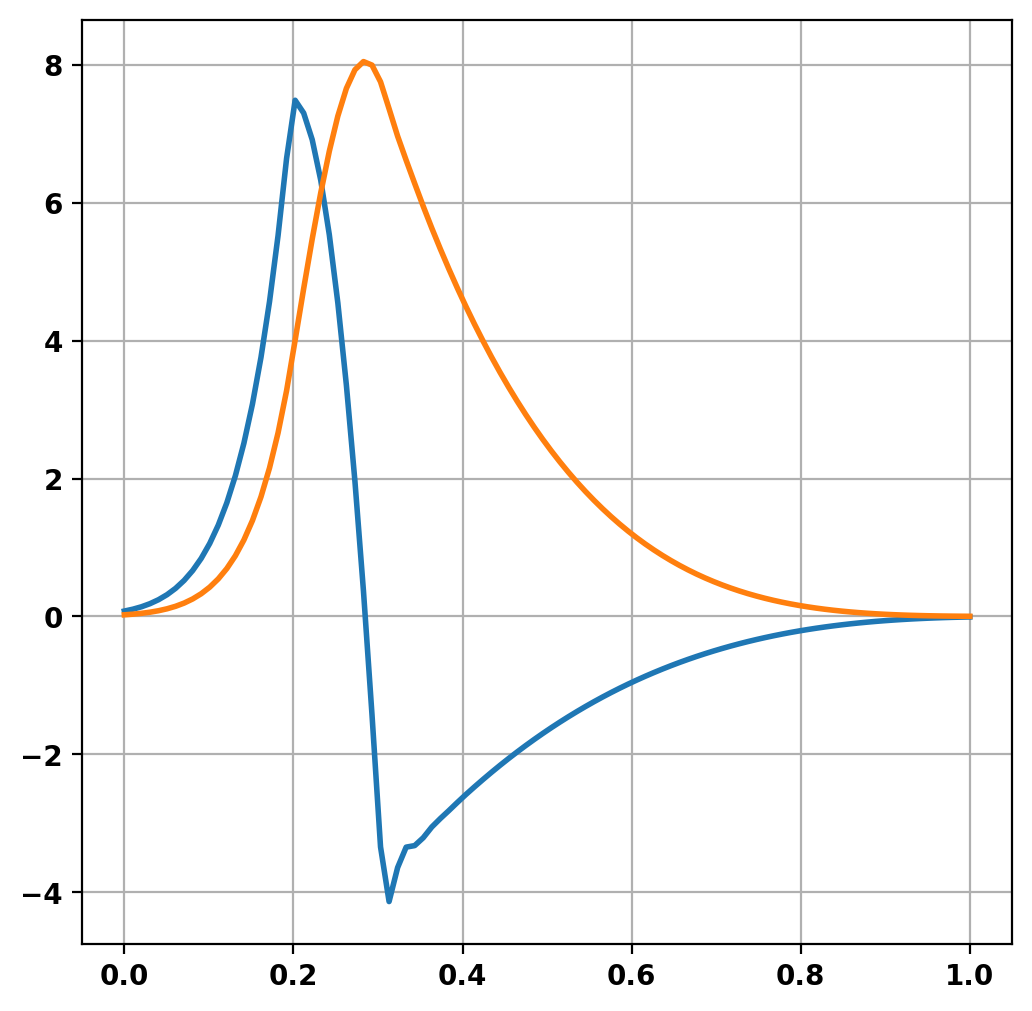

In [9]:
g = 2.5
alpha = 4.0
psi_Lcoil = -0.3
psi_Fcoil = 1.1
x_inner = np.linspace(0.0,0.2,40); y_inner = np.power((x_inner-psi_Lcoil)/(0.25-psi_Lcoil),4*g)
x_outer = np.linspace(0.3,1.0,40); y_outer = np.power((x_outer-psi_Fcoil)/(0.25-psi_Fcoil),alpha)

p_fun = CubicSpline(np.concatenate((x_inner,x_outer)),np.concatenate((y_inner,y_outer)))
pp_fun = p_fun.derivative()
x_sample = np.linspace(0.0,1.0,100)
pp_prof = {
    'type': 'linterp',
    'x': x_sample,
    'y': pp_fun(x_sample)
}
mygs.set_profiles(pp_prof=pp_prof)

fig, ax = plt.subplots(1,1)
ax.plot(pp_prof['x'],pp_prof['y'],label="P'")
ax.plot(pp_prof['x'],p_fun(pp_prof['x'])*10,label="P")
ax.grid(True)

### Perform equilibrium solve
Now we solve for the resulting equilibrium, by first initializing a vacuum state (very low current) and then solving with a given target current.

**Note:** In dipole mode the `pax` constraint corresponds to the peak pressure as there is no magnetic axis.

In [10]:
# Initialize with some tiny current (vacuum flux is all we really want)
mygs.set_targets(Ip=1.E-1)
err_flag = mygs.init_psi()
psi_init = mygs.get_psi()

# Solve with real target
mygs.set_targets(pax=1.E3)
err_flag = mygs.solve()

Starting non-linear GS solver
     1  1.0000E-08 -2.7637E-02  1.9359E-04  2.2301E-01 -1.2679E-02  0.0000E+00
     2  1.0000E-08 -2.8462E-02  1.0047E-04  2.2301E-01 -1.2679E-02  0.0000E+00
     3  1.0000E-08 -2.8913E-02  5.3825E-05  2.2301E-01 -1.2679E-02  0.0000E+00
     4  1.0000E-08 -2.9177E-02  3.0671E-05  2.2301E-01 -1.2679E-02  0.0000E+00
     5  1.0000E-08 -2.9338E-02  1.8216E-05  2.2301E-01 -1.2679E-02  0.0000E+00
     6  1.0000E-08 -2.9439E-02  1.1105E-05  2.2301E-01 -1.2679E-02  0.0000E+00
     7  1.0000E-08 -2.9502E-02  6.8674E-06  2.2301E-01 -1.2679E-02  0.0000E+00
     8  1.0000E-08 -2.9542E-02  4.2969E-06  2.2301E-01 -1.2679E-02  0.0000E+00
     9  1.0000E-08 -2.9568E-02  2.7087E-06  2.2301E-01 -1.2679E-02  0.0000E+00
    10  1.0000E-08 -2.9584E-02  1.7189E-06  2.2301E-01 -1.2679E-02  0.0000E+00
    11  1.0000E-08 -2.9594E-02  1.0984E-06  2.2301E-01 -1.2679E-02  0.0000E+00
    12  1.0000E-08 -2.9601E-02  6.9332E-07  2.2301E-01 -1.2679E-02  0.0000E+00
 Timing:  0.3472460000

### Print information and plot equilibrium
Since most of the current generating the poloidal field is in the dipole, not the plasma itself we use `beta_Ip` to override the current in calculations of $\beta$.

We also compare the flux surfaces in vacuum (red) and with plasma pressure/current (black).

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    2.5262E+05
  Current Centroid [m]    =    1.245  0.070
  Inner limiter [m]       =    0.223 -0.013
  Elongation              =    0.807 (U:  0.966, L:  0.649)
  Triangularity           =   -0.065 (U: -0.121, L: -0.010)
  Plasma Volume [m^3]     =   25.717
  Peak Pressure [Pa]      =    1.0019E+03
  Stored Energy [J]       =    2.2017E+03
  <Beta_pol> [%]          =    5.7847
  Diamagnetic flux [Wb]   =    2.8847E-05
  Toroidal flux [Wb]      =    2.8847E-05
  l_i                     =   11.2824


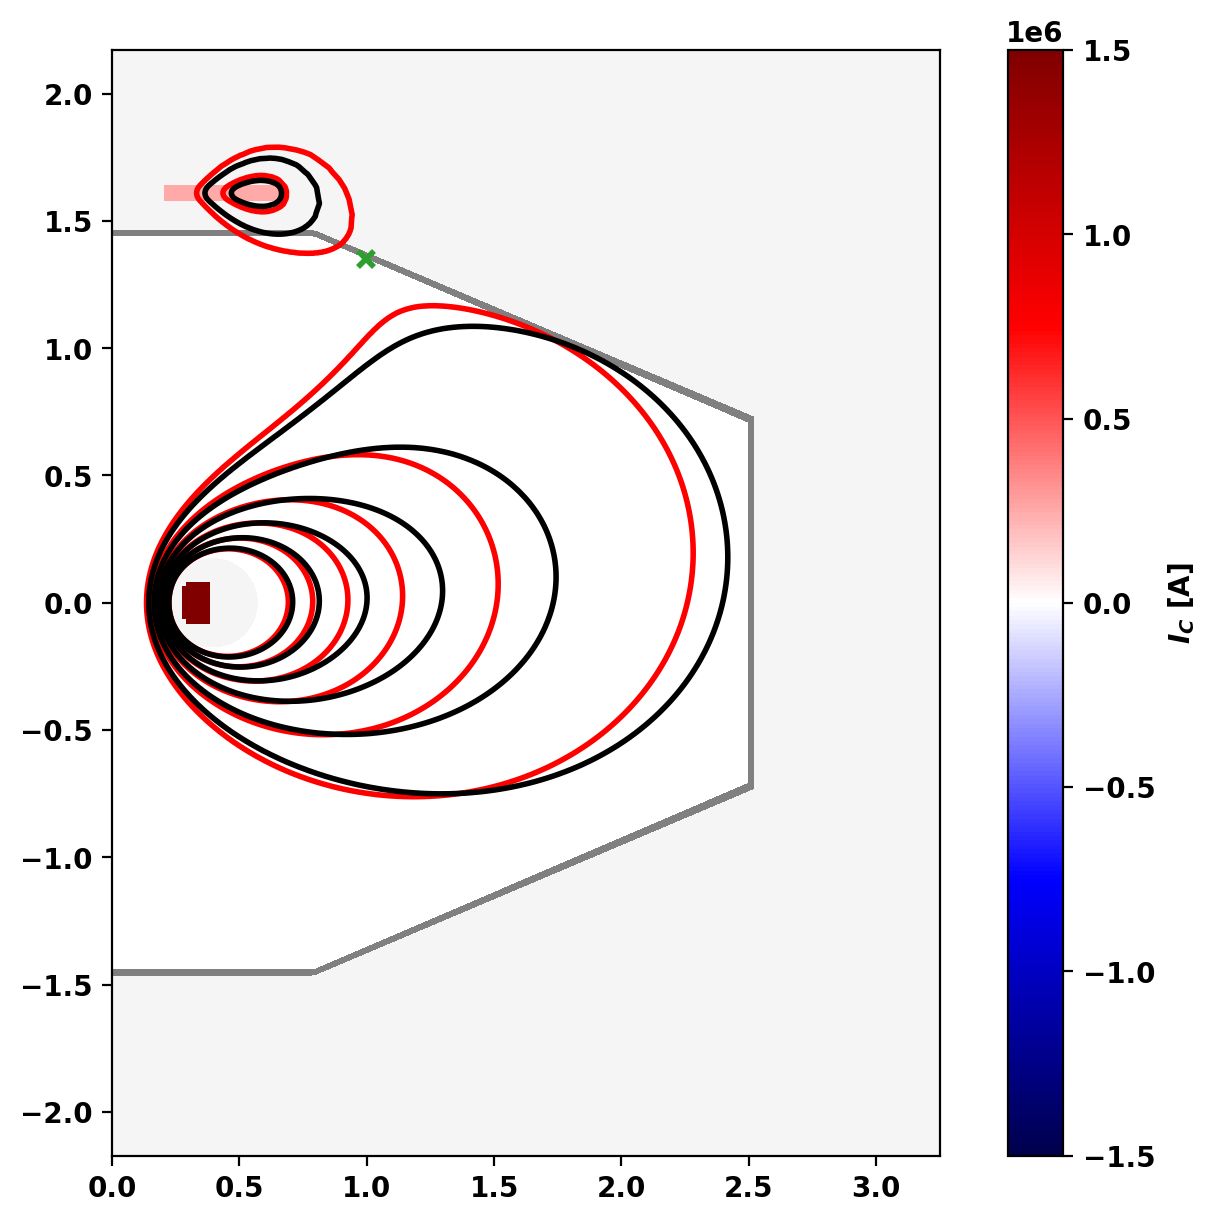

In [11]:
mygs.print_info(beta_Ip=coil_currents['LCOIL']*mygs.coil_sets['LCOIL']['net_turns'])

fig, ax = plt.subplots(1,1,sharey=True,figsize=(8,6),constrained_layout=True)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,limiter_color=None)
mygs.plot_psi(fig,ax,psi=psi_init,plasma_nlevels=6,plasma_color='r',vacuum_nlevels=0,xpoint_color=None,opoint_color=None)
mygs.plot_psi(fig,ax,plasma_nlevels=6,plasma_color='k',vacuum_nlevels=0,xpoint_color='tab:green',opoint_color=None)

We can also plot the toroidal current distribution within the plasma using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_jtor_plasma "get_jtor_plasma()".

Starting CG solver
     0  0.000000E+00  0.000000E+00  5.635482E-04
     1 -8.964078E-04  3.462155E+00  6.367260E-05  1.839103E-05
     2 -9.540550E-04  4.201182E+00  2.024744E-05  4.819462E-06
     3 -9.558032E-04  4.242515E+00  4.200376E-06  9.900674E-07
     4 -9.559372E-04  4.246104E+00  1.448399E-06  3.411124E-07
     5 -9.559502E-04  4.245852E+00  4.590489E-07  1.081170E-07
     6 -9.559517E-04  4.245819E+00  1.699587E-07  4.002965E-08
     7 -9.559519E-04  4.245772E+00  7.344382E-08  1.729811E-08
     8 -9.559519E-04  4.245784E+00  2.900647E-08  6.831829E-09
     9 -9.559519E-04  4.245786E+00  1.131723E-08  2.665521E-09
    10 -9.559519E-04  4.245789E+00  3.796507E-09  8.941819E-10


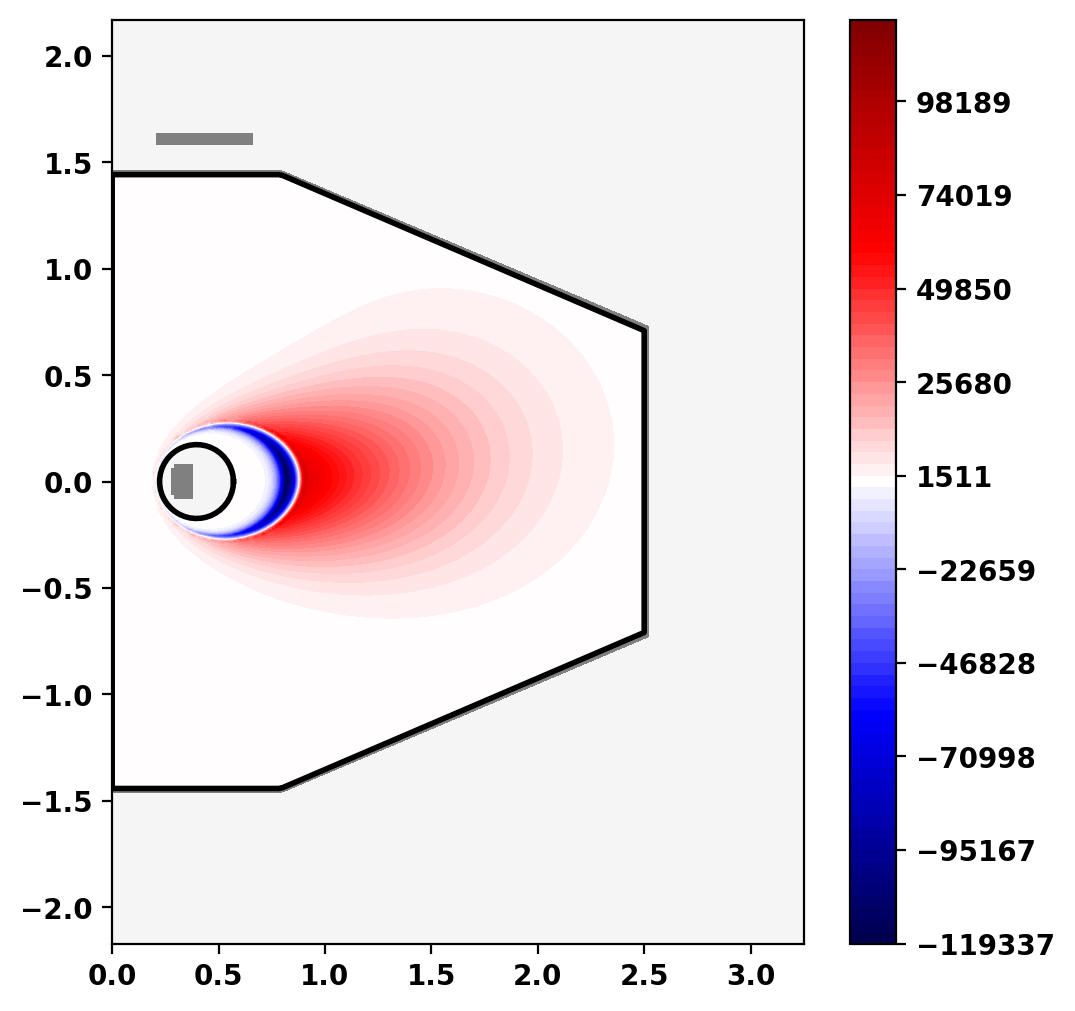

In [12]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap=None)
curr = mygs.get_jtor_plasma()
mask = (mygs.reg == 1)
vmax = (abs(curr)).max()
clf = ax.tricontourf(mygs.r[:,0],mygs.r[:,1],mygs.lc[mask],curr,np.linspace(-vmax,vmax,80),cmap='seismic')
_ = fig.colorbar(clf)

## Compute stability
Now we compute the growth rate of the vertical instability for the floation coil (dipole).

### Compute eddy currents
First, we compute the eddy currents generated by movement of the coil, which will produce a restoring force and decrease the growth rate compared to a case with no VV. To do this we have to compute the flux change in the VV due to movement of the Fcoil, which can be done similar to above for the change in force on the Fcoil by evaluating $d\psi/dz$ within the VV due for field generated by the Fcoil.

   1  5.1467E+01


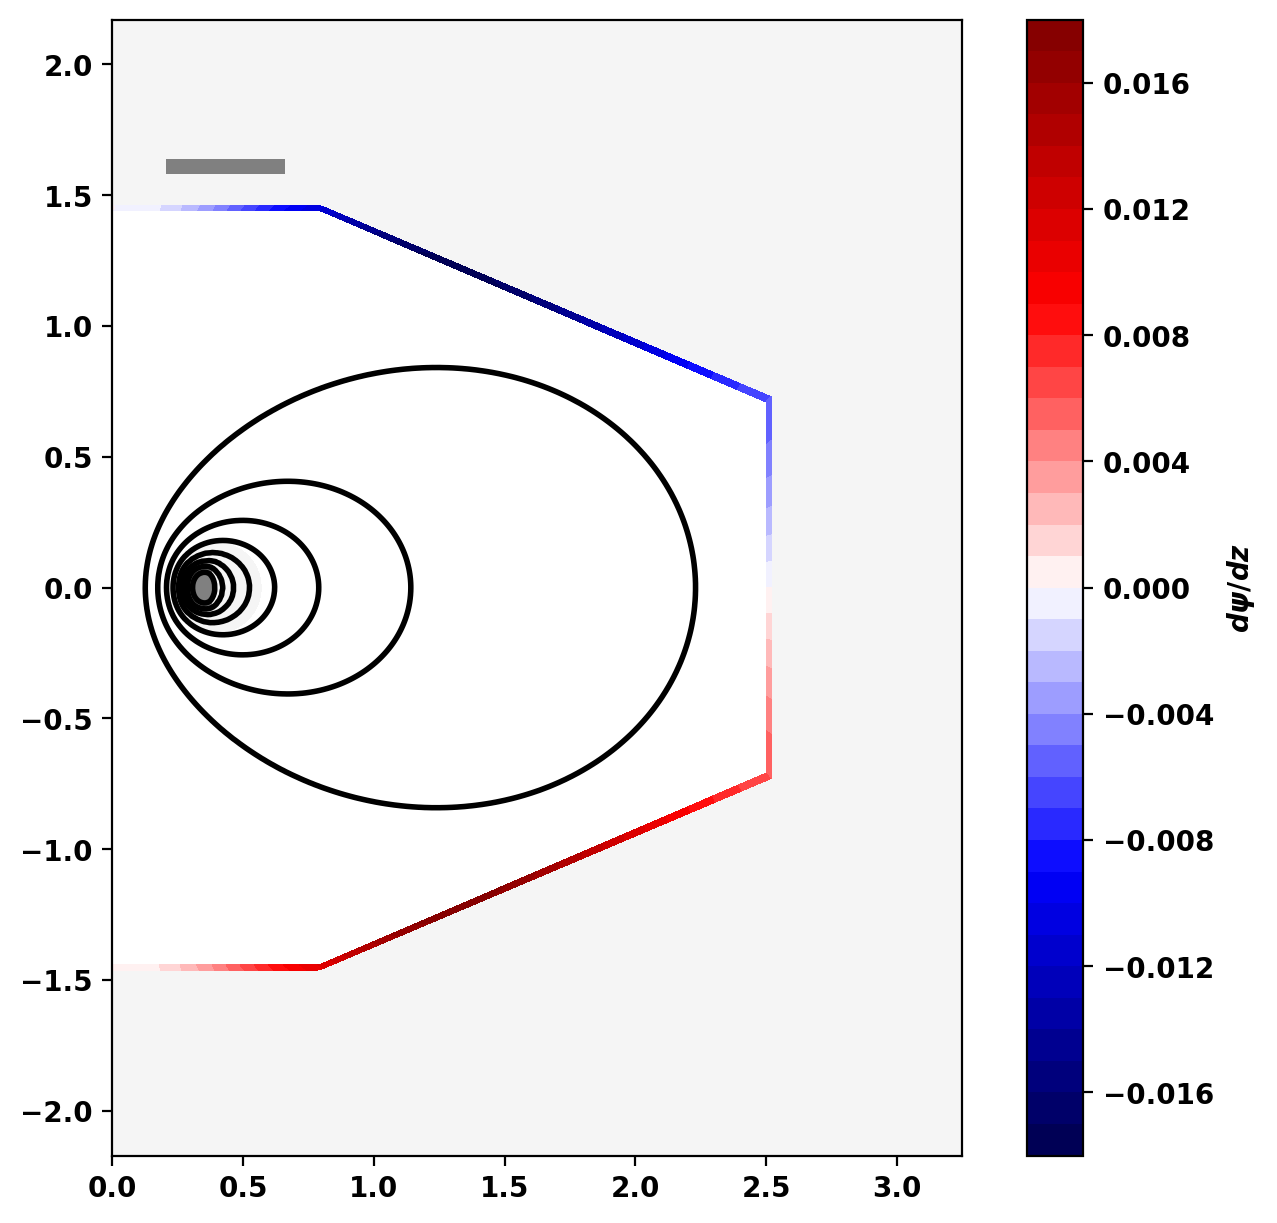

In [13]:
# Compute vacuum field with above equilibrium current in the Fcoil
mygs.set_coil_currents({'FCOIL': coil_currents['FCOIL']})
psi_dipole = mygs.vac_solve()

# Evaluate dBr/dz in VV
mygs.set_psi(psi_dipole)
field_eval = mygs.get_field_eval('dPSI')
dpsi_dipole = np.zeros((mygs.r.shape[0],))
for i in range(mygs.r.shape[0]):
    if mygs.r[i,0] < 1.E-6:
        continue
    Btmp = field_eval.eval(mygs.r[i,:2])
    dpsi_dipole[i] = Btmp[1]

# Plot vacuum field and flux change (voltage source) in VV
fig, ax = plt.subplots(1,1,sharey=True,figsize=(8,6),constrained_layout=True)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,psi=psi_dipole,normalized=False,plasma_nlevels=10,plasma_color='k',vacuum_levels=None,xpoint_color=None,opoint_color=None)
clf = ax.tricontourf(mygs.r[:,0],mygs.r[:,1],mygs.lc[mygs.reg==mygs._cond_dict['VV']['reg_id'],:],dpsi_dipole,levels=40,cmap='seismic')
_ = fig.colorbar(clf,ax=ax,label=r'$d\psi/dz$')

### Compute growth rate
Now we can compute the growth rate using a fixed-point iteration. We begin with the vacuum growth rate $\gamma = dF/dz I_{Fcoil}/m_{Fcoil}$, then at each iteration we compute the eddy currents for the current growth rate and the recompute the growth rate as $\gamma = dF_{Fcoil,Lcoil}/dz I_{Fcoil}/m_{Fcoil} + dF_{Fcoil,VV}/dz*I_{Fcoil}/m_{Fcoil}$. A fairly large under-relaxation factor is used to ensure convergence.

**Note:** For other configurations alternative fixed-point methods (eg. bisection) may be required.

In [14]:
# Setup solver for iteration
mygs.settings.pm=False      # Turn off performance monitoring
mygs.update_settings()      # Update settings
mygs.set_coil_currents({})  # Set coil currents to zero for vacuum solves
urf = 0.7                   # Set under-relaxation factor
vac_force_dz = unit_coil_force_dz*coil_currents['LCOIL'] # Initial vacuum force gradient
wall_force_dz = 0.0         # Initial eddy current force gradient

# Perform fixed-point iteration
gamma_curr = 0.0
for i in range(20):
    # Update gamma with new eddy current effect
    gamma = (vac_force_dz*coil_currents['FCOIL'] + wall_force_dz*coil_currents['FCOIL'])/dipole_mass
    print("  {0:2d} {1:.4E}".format(i,gamma))
    gamma = max(0.0,gamma)
    gamma_curr = gamma*(1.0-urf) + gamma_curr*urf
    if gamma_curr < 0.0:
        raise ValueError('Negative growth rate in iteration')
        
    # Update wall response by computing eddy currents with growth rate of gamma
    dt_curr = 1.0/gamma_curr
    mygs.set_psi_dt(dpsi_dipole*gamma_curr,dt_curr)
    mygs.set_psi(np.zeros_like(dpsi_dipole)) # Necessary temporarily to initialize zero flux for vacuum solves
    psi_last = mygs.vac_solve()
    mygs.set_psi(psi_last)

    # Evaluate Br due to eddy currents within Fcoil
    field_eval = mygs.get_field_eval('B')
    Br_wall = np.zeros((mygs.r.shape[0],))
    for i in range(mygs.r.shape[0]):
        if pt_mask[i] == 0:
            continue
        Btmp = field_eval.eval(mygs.r[i,:2])
        Br_wall[i] = Btmp[0]
    
    # Compute net vertical force gradient on Fcoil due to eddy currents
    wall_force_dz = 0.0
    for sub_coil in mygs.coil_sets['FCOIL']['sub_coils']:
        wall_force_dz = -2.0*np.pi*mygs.area_integral(mygs.r[:,0]*Br_wall,reg_mask=sub_coil['reg_id'])*sub_coil['nturns']/sub_coil['area']

# Print converged growth rate
print()
print('Vertical growth rate = {0:.5E} [1/s]'.format(gamma))

# Reset solver
mygs.set_psi_dt(np.zeros_like(dpsi_dipole),-1.0)
mygs.settings.pm=True
mygs.update_settings()

   0 2.0893E+01
   1 2.0342E+01
   2 1.9357E+01
   3 1.8485E+01
   4 1.7868E+01
   5 1.7475E+01
   6 1.7239E+01
   7 1.7102E+01
   8 1.7023E+01
   9 1.6978E+01
  10 1.6953E+01
  11 1.6939E+01
  12 1.6931E+01
  13 1.6927E+01
  14 1.6924E+01
  15 1.6923E+01
  16 1.6922E+01
  17 1.6921E+01
  18 1.6921E+01
  19 1.6921E+01

Vertical growth rate = 1.69211E+01 [1/s]


### Plot eddy current distribution and flux

Starting CG solver
     0  0.000000E+00  0.000000E+00  2.778463E-03
     1 -2.090010E-02  2.323090E+01  1.342922E-03  5.780758E-05
     2 -2.561853E-02  2.851730E+01  6.223176E-04  2.182246E-05
     3 -2.639301E-02  2.992876E+01  2.449039E-04  8.182896E-06
     4 -2.650215E-02  3.018588E+01  1.015446E-04  3.363977E-06
     5 -2.652040E-02  3.015018E+01  3.966899E-05  1.315713E-06
     6 -2.652267E-02  3.011409E+01  1.632989E-05  5.422673E-07
     7 -2.652305E-02  3.009945E+01  6.825510E-06  2.267653E-07
     8 -2.652311E-02  3.009743E+01  2.946035E-06  9.788330E-08
     9 -2.652312E-02  3.009760E+01  1.090535E-06  3.623329E-08
    10 -2.652312E-02  3.009778E+01  4.057441E-07  1.348087E-08
    20 -2.652312E-02  3.009803E+01  3.306643E-11  1.098624E-12


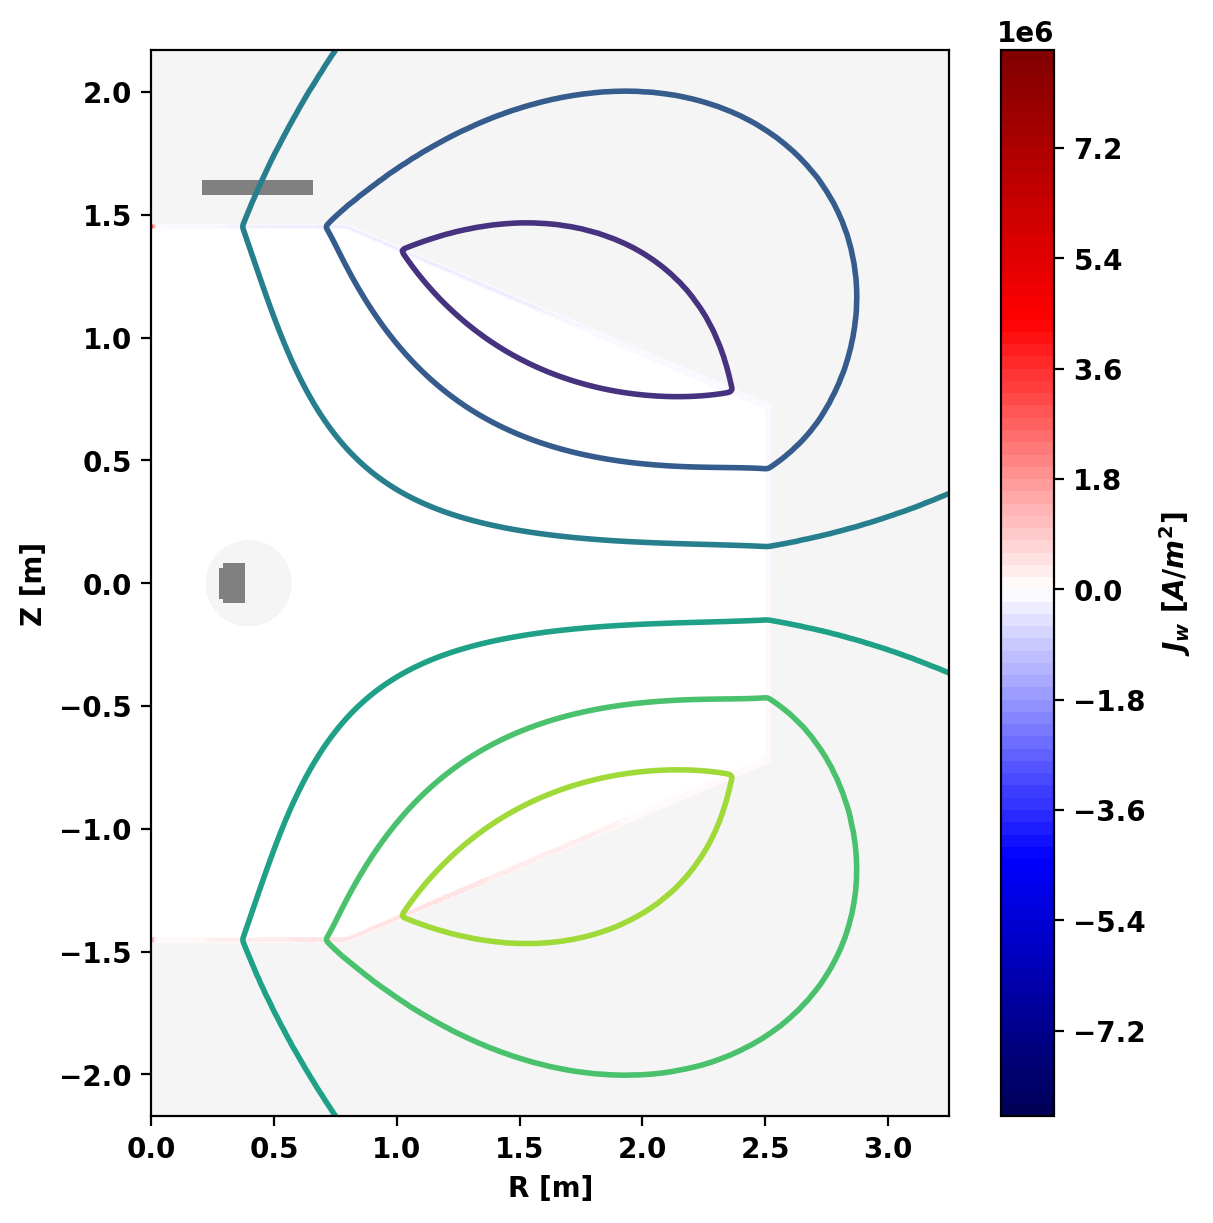

In [15]:
fig, ax = plt.subplots(1,1,sharey=True,figsize=(6,6),constrained_layout=True)
mygs.plot_machine(fig,ax,coil_colormap=None,limiter_color=None)
mygs.plot_psi(fig,ax,psi=psi_last,normalized=False,vacuum_levels=None,xpoint_color=None,opoint_color=None)
mygs.plot_eddy(fig,ax,psi=psi_last,colormap='seismic',symmap=True,nlevels=100)

# Format plots
ax.set_ylabel('Z [m]')
ax.set_xlabel('R [m]')
_ = ax.set_xlabel('R [m]')